In [2]:
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Extract Spectral Peaks as inverted list

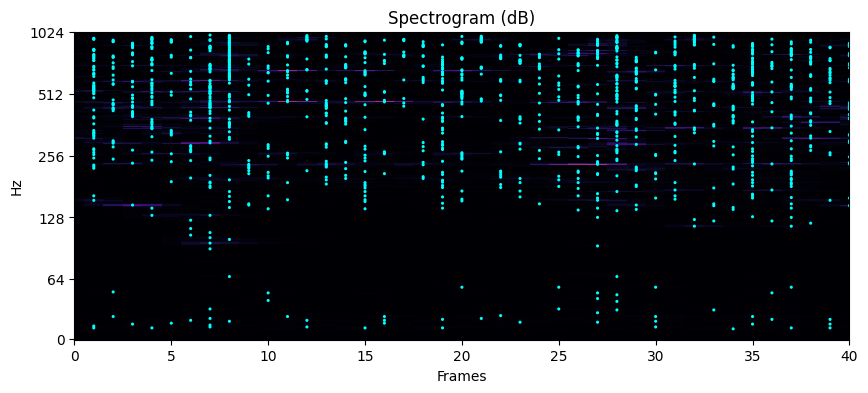

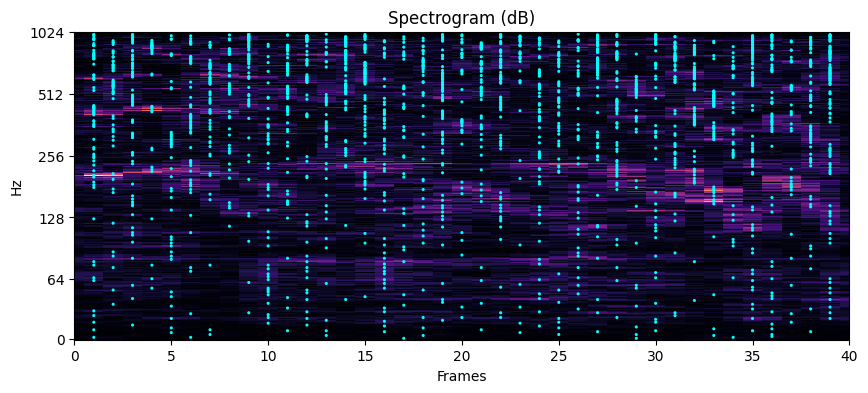

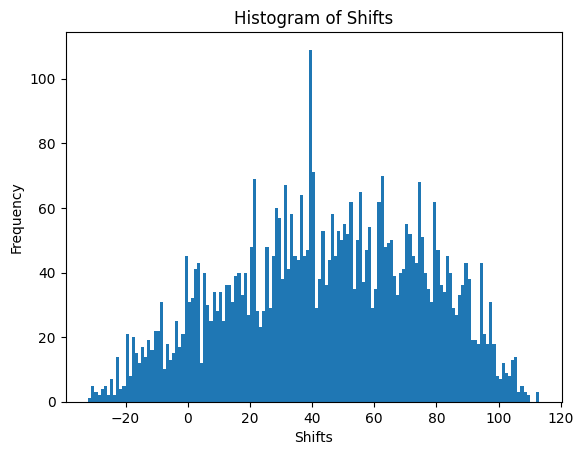

39 109


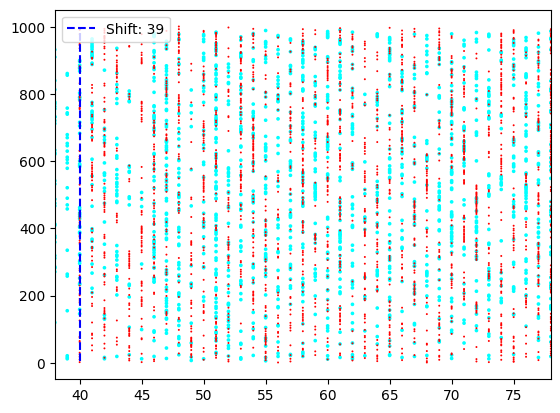

In [52]:
from skimage.feature import peak_local_max
from collections import Counter
    
def fingerprint_database():
    print('')
    # the function that contains the loading, fingerprinting logic for a single database item.

def peak_pick(y, sr, window_hop=1, window_size=24, threshhold=0.1, show=False):    
    # take STFT
    stft = np.abs(librosa.stft(y))
    # stft = stft / np.max(stft) # normalise 0 - 1
            
    peaks = [] # save time-freq bin
    
    # this creates duplicates  
    # for each kernal - refactor to use numpy iterators
    
    # for row in range(0, stft.shape[0] - window_size + 1, window_hop):
    #     for col in range(0, stft.shape[1] - window_size + 1, window_hop):
    #         stft_kernel = stft[row:row+window_size, col:col+window_size]
    #         max_index = np.argmax(stft_kernel)
            
    #         # Get x/y index
    #         index_y, index_x = np.unravel_index(max_index, stft_kernel.shape)
            
    #         # Adjust indices based on current position
    #         index_x += col
    #         index_y += row
            
    #         if(stft[index_y, index_x] < threshhold): continue # apply threshold
            
            
    #         peaks.append([index_y, index_x])
    
    # num_freqs, num_times = stft.shape
    
    # for freq in range(window_size, num_freqs - window_size):
    #     for time in range(window_size, num_times - window_size):
    #         current = stft[freq, time]
    #         if current < threshhold:
    #             continue  # Skip if current point is below the minimum height
                
    #         # Define the neighborhood around the current point
    #         neighborhood = stft[freq - window_size:freq + window_size + 1, time - window_size:time + window_size + 1]
            
    #         # Flatten the neighborhood and remove the current point
    #         neighborhood = neighborhood.flatten()
    #         current_index = len(neighborhood) // 2  # Index of the current point in the flattened neighborhood
    #         neighborhood = np.delete(neighborhood, current_index)
            
    #         # Check if the current point is greater than all its neighbors
    #         if current > np.max(neighborhood):
    #             peaks.append((freq, time))
     
    peaks = peak_local_max(stft, min_distance=window_hop, threshold_abs=threshhold)
    
    if show: plot_spec_peaks(stft, sr, peaks)

    return peaks # index of peaks

def inverted_list(items): # generalise this function
    inverted_l = {}
    # get all frequency index - associate with timestamp indexes
    for item in items:
        hash = item[0] # frequency hash (key)
        value = item[1] # timestamp value
        if hash not in inverted_l: # add new key (frequency hash)
            inverted_l[hash] = []  # init with empty list
        inverted_l[hash].append(value)
    
    # sort timestamps
    for key in inverted_l: # is this needed?
        inverted_l[key].sort()
    
    return inverted_l
    
def identify(Q, D, show=False):    
    shift_counter = Counter() # counter for shift frequency
    
    for h_q in Q: # for each hash index in query
        if h_q not in D: continue # only search hash indexes in query
        m = D[h_q] - Q[h_q]
        shift_counter[m] += 1
    
    most_common_m, count = shift_counter.most_common(1)[0]
    
    # specify bin edges based on the range and distribution shifts
    min_shift = min(shift_counter.keys())
    max_shift = max(shift_counter.keys())
    bin_width = 1
    bins = range(min_shift, max_shift + bin_width, bin_width)
    
    if show: 
        # Plotting the histogram of shifts with manually specified bins
        plt.hist(list(shift_counter.keys()), weights=list(shift_counter.values()), bins=bins)
        plt.xlabel('Shifts')
        plt.ylabel('Frequency')
        plt.title('Histogram of Shifts')
        plt.show()
        print(most_common_m, count)
    
    return most_common_m
    # print("Shift: {}".format(shift))

 
# use every point in constelation map as anchor then find pair in target zone        
def peak_combinations(peaks, target_size=20):
    # target = x,y coord
    combinations = {}
    peaks = np.array(peaks)
    
    # set each peak as an anchor
    for anchor in peaks: 
        # define the current target bounds
        upper_bound = anchor + target_size
        
        # find peaks in target range
        neighbours = peaks[(peaks > anchor).all(axis=1) & (peaks < upper_bound).all(axis=1)]
        
        # combine anchor with each neighbour and time diff
        for neighbour in neighbours: 
            time_stamp = anchor[1]
            time_diff = neighbour[1] - time_stamp
            hash = (anchor[0], neighbour[0], time_diff) # decompose values since anchor and neighbour are numpy arrays
            
            if hash not in combinations:
                combinations[hash] = time_stamp # add new key
            else:
                combinations[hash] = time_stamp
    
    return combinations
        
def plot_spec_peaks(spec, sr, peaks):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, y_axis="log", sr=sr, x_axis='frames')
    plt.title('Spectrogram (dB)')
    
    # get the indexes
    index_y, index_x = zip(*peaks)
    # plot the points on top of the spectrogram
    plt.scatter(index_x, index_y, color='cyan', s=5, edgecolor='none')

    plt.xlim([0,40])
    # plt.ylim([0,825])
    plt.show()

def plot_shift(Q_peaks, D_peaks, shift):
    D_y, D_x = zip(*D_peaks)
    Q_y, Q_x = zip(*Q_peaks)
    
    Q_x_shifted = [x + shift for x in Q_x] # apply shift
    
    plt.vlines(shift+1, ymin=min(D_y), ymax=max(D_y), color='b', linestyle='--', label='Shift: {}'.format(shift))
    plt.scatter(D_x, D_y, color='cyan', s=7, edgecolor='none')
    plt.scatter(Q_x_shifted, Q_y, color='red', s=2, edgecolor='none')
    
    plt.xlim([shift-1, max(Q_x_shifted)])
    # plt.ylim([600,800])
    plt.legend()
    plt.show()
    

database_file = "_database_recordings/classical.00085.wav"
query_file = "_query_recordings/classical.00085-snippet-10-10.wav"
resample_rate = 2048

# database document
db_y, sr = librosa.load(database_file, sr=resample_rate)
peaks_D  = peak_pick(db_y, sr, show=True)
F_D      = peak_combinations(peaks_D)
# F_D = inverted_list(peaks_D)
# print(F_D)

# query document
q_y, sr = librosa.load(query_file, sr=resample_rate)
peaks_Q = peak_pick(q_y, sr, show=True)
F_Q     = peak_combinations(peaks_Q)
# F_Q = inverted_list(peaks_Q)
# print(F_Q)

m_shift = identify(F_Q, F_D, show=True)

plot_shift(peaks_Q, peaks_D, m_shift)